In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.5 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [ ]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch
import numpy as np
from collections import deque, namedtuple
import torch.distributions as distributions

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [ ]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('CartPole-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print('state_shape ',state_shape)
print('no_of_actions ',no_of_actions)
print('env.action_space.sample() ',env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print('state ', state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print('action ',action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print('next_state ', next_state)
print('reward ',reward)
print('done ',done)
print('info ',info)
print("----")


state_shape  4
no_of_actions  2
env.action_space.sample()  1
----
state  [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
----
action  1
----
next_state  [ 0.01323574  0.17272775 -0.04686959 -0.3551522 ]
reward  1.0
done  False
info  {}
----


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


In [ ]:


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-3               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


In [ ]:
def run():
  class network_nn(nn.Module):

      def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
          """Initialize parameters and build model."""
          super(network_nn, self).__init__()
          self.seed = torch.manual_seed(seed)

          # Common feature extraction layers
          self.fc1 = nn.Linear(state_size, fc1_units)
          self.fc2 = nn.Linear(fc1_units, fc2_units)
          self.fc3 = nn.Linear(fc2_units, action_size)


      def forward(self, state):
          """Build a network that maps state -> action values."""
          x = F.relu(self.fc1(state))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)

          return x
  state_shape = env.observation_space.shape[0]
  action_shape = env.action_space.n

  mc_policy_reinforce = network_nn(state_size=state_shape, action_size=action_shape, seed=0)
  optimizer = optim.Adam(mc_policy_reinforce.parameters(), lr=LR)
  def init_weights(m):
      if type(m) == nn.Linear:
          torch.nn.init.xavier_normal_(m.weight)
          m.bias.data.fill_(0)
  mc_policy_reinforce.apply(init_weights)



  def train(env, mc_policy_reinforce, optimizer, discount_factor):

      mc_policy_reinforce.train()

      actions_log_probability = []
      rewards = []
      done = False
      Episodic_rewards = 0

      state_env = env.reset()

      while not done:

          state_env = torch.FloatTensor(state_env).unsqueeze(0)

          prediction_Action = mc_policy_reinforce(state_env)

          probability_Actions = F.softmax(prediction_Action, dim = -1)

          distributions_D = distributions.Categorical(probability_Actions)

          action = distributions_D.sample()

          log_prob_action = distributions_D.log_prob(action)

          state_env, reward, done, _ = env.step(action.item())

          actions_log_probability.append(log_prob_action)
          rewards.append(reward)

          Episodic_rewards += reward

      actions_log_probability = torch.cat(actions_log_probability)

      returns = calculate_returns(rewards, discount_factor)

      loss = update_mc_policy_reinforce(returns, actions_log_probability, optimizer)

      return loss, Episodic_rewards


  def calculate_returns(rewards, discount_factor, normalize = True):

    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns)

    if normalize:
        returns = (returns - returns.mean()) / returns.std()

    return returns


  def update_mc_policy_reinforce(returns, log_prob_actions, optimizer):

      returns = returns.detach()

      loss = - (returns * log_prob_actions).sum()

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      return loss.item()
  def evaluate(env, mc_policy_reinforce):

      mc_policy_reinforce.eval()

      done = False
      episode_reward = 0

      state_Env = env.reset()

      while not done:

          state_Env = torch.FloatTensor(state_Env).unsqueeze(0)

          with torch.no_grad():

              prediction_Action = mc_policy_reinforce(state_Env)

              probability_Actions = F.softmax(prediction_Action, dim = -1)

          action = torch.argmax(probability_Actions, dim = -1)

          state_Env, reward, done, _ = env.step(action.item())

          episode_reward += reward

      return episode_reward

  reward_thshold = 195.0
  max_ep = 300
  gamma = 0.99
  Print = 50
  n_trails = 100


  rewards = deque(maxlen=100)

  avg_reward = []
  eps = []

  for episode in range(1, max_ep+1):

      loss, reward = train(env, mc_policy_reinforce, optimizer, gamma)

      # test_reward = evaluate(test_env, mc_policy_reinforce)

      rewards.append(reward)
      # test_rewards.append(test_reward)

      mean_rewards = np.mean(rewards)
      avg_reward.append(mean_rewards)
      eps.append(episode)

      if episode % Print == 0:

          print(f'| Episode: {episode:3} | Mean Rewards: {mean_rewards:5.1f} |')

      # if mean_rewards >= reward_thshold:

      #     print(f'Reached reward threshold in {episode} episodes with mean reward {mean_rewards}')

          # break
  return eps, avg_reward

In [ ]:
t1_eps, t1_avg_reward = [], []
for i in range(20):
  print(i)
  eps, rwd = run()
  t1_eps = eps
  t1_avg_reward.append(rwd)

0
| Episode:  50 | Mean Rewards:  13.5 |
| Episode: 100 | Mean Rewards:  20.3 |
| Episode: 150 | Mean Rewards:  35.0 |
| Episode: 200 | Mean Rewards:  51.4 |
| Episode: 250 | Mean Rewards:  67.9 |
| Episode: 300 | Mean Rewards:  91.1 |
1
| Episode:  50 | Mean Rewards:  53.6 |
| Episode: 100 | Mean Rewards: 169.3 |
| Episode: 150 | Mean Rewards: 302.3 |
| Episode: 200 | Mean Rewards: 247.3 |
| Episode: 250 | Mean Rewards: 243.0 |
| Episode: 300 | Mean Rewards: 376.3 |
2
| Episode:  50 | Mean Rewards:  21.4 |
| Episode: 100 | Mean Rewards:  51.2 |
| Episode: 150 | Mean Rewards: 123.6 |
| Episode: 200 | Mean Rewards: 306.9 |
| Episode: 250 | Mean Rewards: 417.9 |
| Episode: 300 | Mean Rewards: 374.8 |
3
| Episode:  50 | Mean Rewards:  79.7 |
| Episode: 100 | Mean Rewards: 132.0 |
| Episode: 150 | Mean Rewards: 250.6 |
| Episode: 200 | Mean Rewards: 239.8 |
| Episode: 250 | Mean Rewards: 265.8 |
| Episode: 300 | Mean Rewards: 432.4 |
4
| Episode:  50 | Mean Rewards:  34.1 |
| Episode: 100 

In [ ]:
def run2():
  class network_nn(nn.Module):

      def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
          """Initialize parameters and build model."""
          super(network_nn, self).__init__()
          self.seed = torch.manual_seed(seed)

          # Common feature extraction layers
          self.fc1 = nn.Linear(state_size, fc1_units)
          self.fc2 = nn.Linear(fc1_units, fc2_units)
          # State value function
          self.fc3_val = nn.Linear(fc2_units, 1)

          # baseline function
          self.fc3_baseline = nn.Linear(fc2_units, action_size)


      def forward(self, state):
          """Build a network that maps state -> action values."""
          x = F.relu(self.fc1(state))
          x = F.relu(self.fc2(x))

          # State value calculation
          val = self.fc3_val(x)

          # baseline value calculation
          baseline = self.fc3_baseline(x)

          # Combine state value and baselinee
          return val + baseline - baseline.mean()

  state_shape = env.observation_space.shape[0]
  action_shape = env.action_space.n

  mc_policy_reinforce = network_nn(state_size=state_shape, action_size=action_shape, seed=0)
  optimizer = optim.Adam(mc_policy_reinforce.parameters(), lr=LR)
  def init_weights(m):
      if type(m) == nn.Linear:
          torch.nn.init.xavier_normal_(m.weight)
          m.bias.data.fill_(0)
  mc_policy_reinforce.apply(init_weights)




  def train(env, mc_policy_reinforce, optimizer, discount_factor):

      mc_policy_reinforce.train()

      actions_log_probability = []
      rewards = []
      done = False
      Episodic_rewards = 0

      state_env = env.reset()

      while not done:

          state_env = torch.FloatTensor(state_env).unsqueeze(0)

          prediction_Action = mc_policy_reinforce(state_env)

          probability_Actions = F.softmax(prediction_Action, dim = -1)

          distributions_D = distributions.Categorical(probability_Actions)

          action = distributions_D.sample()

          log_prob_action = distributions_D.log_prob(action)

          state_env, reward, done, _ = env.step(action.item())

          actions_log_probability.append(log_prob_action)
          rewards.append(reward)

          Episodic_rewards += reward

      actions_log_probability = torch.cat(actions_log_probability)

      returns = calculate_returns(rewards, discount_factor)

      loss = update_mc_policy_reinforce(returns, actions_log_probability, optimizer)

      return loss, Episodic_rewards


  def calculate_returns(rewards, discount_factor, normalize = True):

    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns)

    if normalize:
        returns = (returns - returns.mean()) / returns.std()

    return returns


  def update_mc_policy_reinforce(returns, log_prob_actions, optimizer):

      returns = returns.detach()

      loss = - (returns * log_prob_actions).sum()

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      return loss.item()
  def evaluate(env, mc_policy_reinforce):

      mc_policy_reinforce.eval()

      done = False
      episode_reward = 0

      state_Env = env.reset()

      while not done:

          state_Env = torch.FloatTensor(state_Env).unsqueeze(0)

          with torch.no_grad():

              prediction_Action = mc_policy_reinforce(state_Env)

              probability_Actions = F.softmax(prediction_Action, dim = -1)

          action = torch.argmax(probability_Actions, dim = -1)

          state_Env, reward, done, _ = env.step(action.item())

          episode_reward += reward

      return episode_reward

  reward_thshold = 195.0
  max_ep = 300
  gamma = 0.99
  Print = 50
  n_trails = 100


  rewards = deque(maxlen=100)

  avg_reward = []
  eps = []

  for episode in range(1, max_ep+1):

      loss, reward = train(env, mc_policy_reinforce, optimizer, gamma)

      # test_reward = evaluate(test_env, mc_policy_reinforce)

      rewards.append(reward)
      # test_rewards.append(test_reward)

      mean_rewards = np.mean(rewards)
      avg_reward.append(mean_rewards)
      eps.append(episode)

      if episode % Print == 0:

          print(f'| Episode: {episode:3} | Mean Rewards: {mean_rewards:5.1f} |')

      # if mean_rewards >= reward_thshold:

      #     print(f'Reached reward threshold in {episode} episodes with mean reward {mean_rewards}')

          # break
  return eps, avg_reward

In [ ]:
t2_eps, t2_avg_reward = [], []
for i in range(20):
  print(i)
  eps, rwd = run2()
  t2_eps = eps
  t2_avg_reward.append(rwd)

0
| Episode:  50 | Mean Rewards:  27.4 |
| Episode: 100 | Mean Rewards:  71.1 |
| Episode: 150 | Mean Rewards: 143.8 |
| Episode: 200 | Mean Rewards: 129.5 |
| Episode: 250 | Mean Rewards:  68.8 |
| Episode: 300 | Mean Rewards:  66.3 |
1
| Episode:  50 | Mean Rewards:  62.8 |
| Episode: 100 | Mean Rewards:  82.5 |
| Episode: 150 | Mean Rewards: 129.2 |
| Episode: 200 | Mean Rewards:  98.2 |
| Episode: 250 | Mean Rewards:  32.6 |
| Episode: 300 | Mean Rewards:  31.3 |
2
| Episode:  50 | Mean Rewards: 146.2 |
| Episode: 100 | Mean Rewards: 290.2 |
| Episode: 150 | Mean Rewards: 433.6 |
| Episode: 200 | Mean Rewards: 409.6 |
| Episode: 250 | Mean Rewards: 320.9 |
| Episode: 300 | Mean Rewards: 302.6 |
3
| Episode:  50 | Mean Rewards: 191.5 |
| Episode: 100 | Mean Rewards: 259.3 |
| Episode: 150 | Mean Rewards: 298.5 |
| Episode: 200 | Mean Rewards: 142.0 |
| Episode: 250 | Mean Rewards:  54.7 |
| Episode: 300 | Mean Rewards: 121.1 |
4
| Episode:  50 | Mean Rewards:  39.3 |
| Episode: 100 

In [ ]:
r1 = np.mean(np.array(t1_avg_reward), axis=0)
std1 = np.std(np.array(t1_avg_reward), axis=0)

In [ ]:
r2 = np.mean(np.array(t2_avg_reward), axis=0)
std2 = np.std(np.array(t2_avg_reward), axis=0)

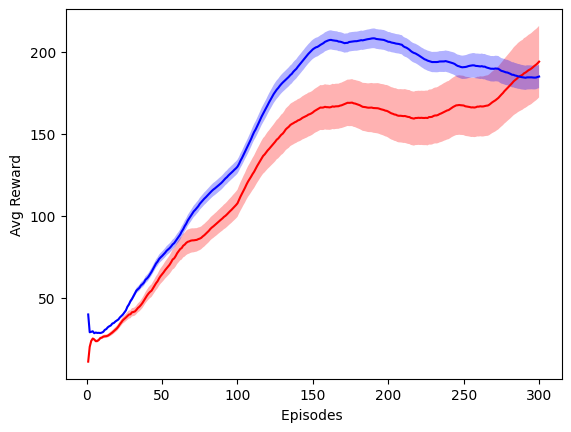

In [ ]:

plt.figure()
plt.plot(t1_eps,r1,'r')
plt.fill_between(t1_eps, r1+ (std1), r1-(std1), facecolor='red', alpha=0.3)

plt.plot(t1_eps,r2,'b')
plt.fill_between(t1_eps, r2+ (std2), r2-(std2), facecolor='blue', alpha=0.3)
plt.xlabel('Episodes ')
plt.ylabel('Avg Reward')
plt.show()